In [1]:
from _preprocessing import CryptoCompareReader
test_reader = CryptoCompareReader('btc', '../splits/test', drop_na_subset=['close'], add_time_columns=True,
                                  drop_last=True)
train_reader = CryptoCompareReader('btc', '../splits/train', drop_na_subset=['close'], add_time_columns=True,
                                   drop_last=True)

test_df = test_reader.read()[['time','close']]
train_data = train_reader.read()[['time','close']]

D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


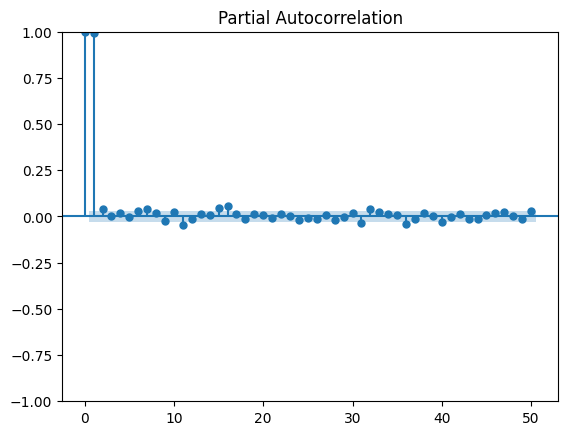

In [2]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train_data['close'].values, lags=50);

In [2]:
from sktime.forecasting.arima import ARIMA
forecaster = ARIMA(order=(3,1,3))
forecaster.fit(train_data['close'].values,fh=list(range(5)))
forecaster.summary()

D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3820
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -26245.236
Date:                Mon, 31 Oct 2022   AIC                          52506.471
Time:                        17:13:45   BIC                          52556.453
Sample:                             0   HQIC                         52524.230
                               - 3820                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7060      0.728      0.970      0.332      -0.720       2.132
ar.L1         -0.6659      0.015    -45.625      0.000      -0.695      -0.637
ar.L2          0.7006      0.012     60.735      0.000       0.678       0.723
ar.L3          0.9007      0.015     60.973      0.000       0.872       0.930
ma.L1          0.6648      0.017     40.180      0.000       0.632       0.697
ma.L2         -0.6910      0.014    -50.384      0.000      -0.718      -0.664
ma.L3         -0.8521      0.017    -49.874      0.000      -0.886      -0.819
sigma2      5.417e+04    317.412    170.648      0.000    5.35e+04    5.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.37   Jarque-Bera (JB):            183551.46
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):             342.95   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3]:
from sklearn.linear_model import LinearRegression
import numpy as np
test_data = test_df['close'].values.tolist()
lm = LinearRegression(fit_intercept=False)
forecasts = []
from statsmodels.tsa.arima.model import ARIMA
idx = 10
while idx < len(test_df):

    values_to_fit = train_data['close'].values.tolist() + test_df['close'].iloc[:idx].tolist()
    forecaster = ARIMA(values_to_fit,order=(3,1,3))
    forecaster = forecaster.fit()
    forecast = forecaster.forecast(steps=5)

    if np.std(forecast) != 0:
        scaled = (forecast - forecast[0]) / np.std(forecast)
        lm.fit(np.array(list(range(len(scaled)))).reshape(-1, 1), scaled)
        coef = lm.coef_[0]
        label = 0 if coef <= 0 else 1
        forecasts.append(label)
    else:
        forecasts.append(0)
    idx+=1

D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_

In [4]:
test_trimmed = test_df.iloc[10:-5]
forecasts_trimmed = forecasts[:-5]
print(len(forecasts_trimmed)-len(test_trimmed))

0


In [6]:
len(forecasts_trimmed)

552

In [8]:
test_y = np.load('../splits/test/y_preprocessed_h0_p0.npy',allow_pickle=True)
test_y = np.argmax(test_y,axis=1)
len(test_y)

552

In [9]:
from sklearn.metrics import accuracy_score

accuracy_score(test_y,forecasts_trimmed)

0.5018115942028986

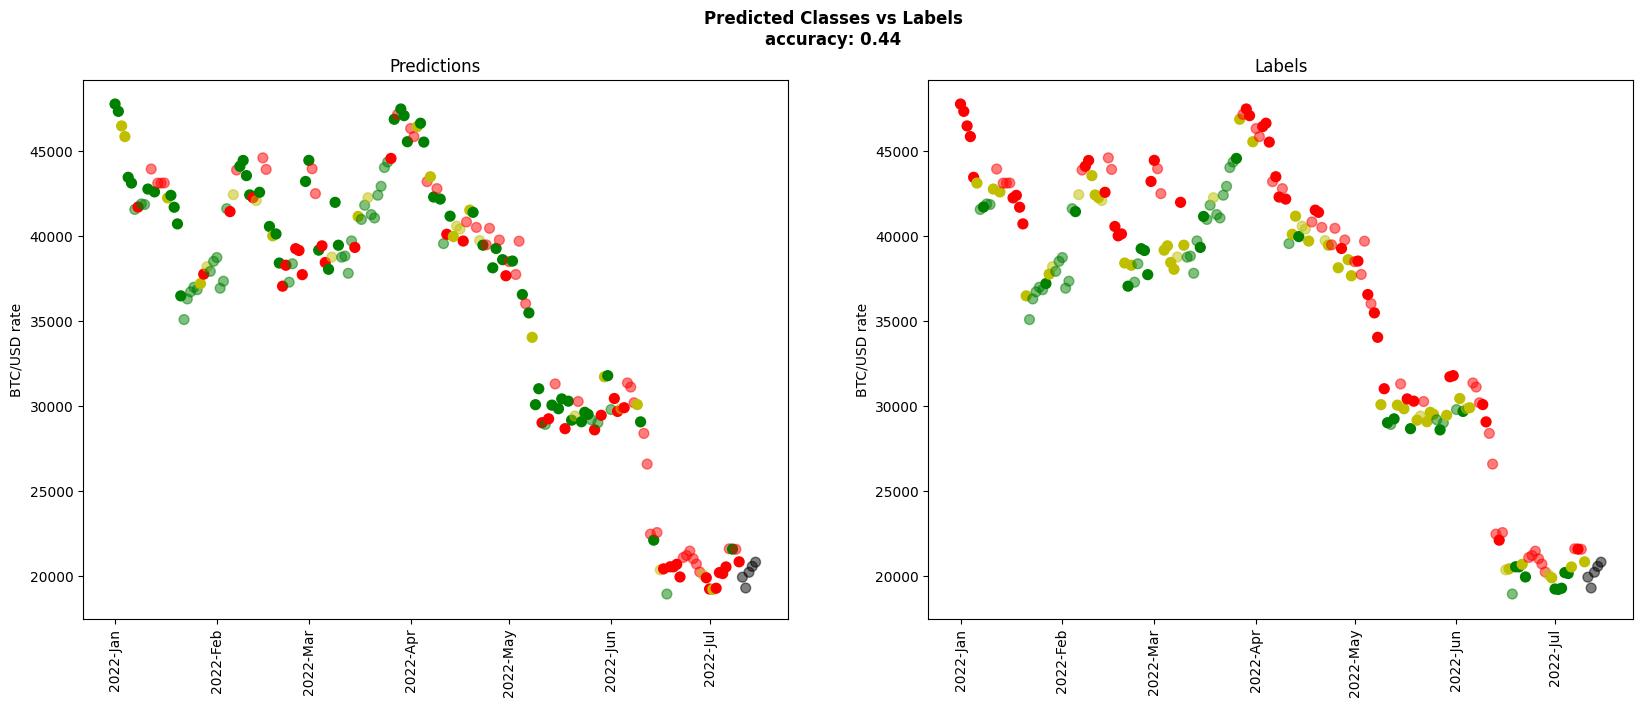

In [40]:
import os
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import evaluation
import importlib
importlib.reload(evaluation)
lm = LinearRegression(fit_intercept=False)

classifier = lambda value : 0 if value <-0.2 else 1 if value <= 0.2 else 2

def reg_classifier(window):

    if np.std(window) == 0:
        return 1
    scaled = (window - window[0]) / np.std(window)
    lm.fit(np.array(list(range(len(scaled)))).reshape(-1, 1), scaled)

    return classifier(lm.coef_[0])


y_true = np.array(list(map(reg_classifier,windows)))
y_pred = np.array(list(map(classifier,forecasts)))

# y_true = np.reshape(y_true,(len(y_true),1))
# y_pred = np.reshape(y_pred,(len(y_pred),1))

colors, pred_colors, true_colors = evaluation._get_prediction_colors(y_pred, y_true, banned_indices=list(range(len(y_pred),len(y_pred)-7,-1)), test_data=test_df.iloc[:-7])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
diffs = np.abs(y_pred - y_true)
acc = 1 - int(np.count_nonzero(diffs)) / int(len(y_pred))
plt.suptitle(f'Predicted Classes vs Labels\naccuracy: {round(acc, 2)}', fontweight="bold")
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 12, 1)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax.tick_params(axis='x', labelrotation=90)

axes[0].scatter(test_df['time'].iloc[:-7], test_df["close"].iloc[:-7], c=pred_colors, s=50)
axes[0].set_title('Predictions')
axes[0].set_ylabel('BTC/USD rate')

axes[1].scatter(test_df['time'].iloc[:-7], test_df["close"].iloc[:-7], c=true_colors, s=50)
axes[1].set_title('Labels')
axes[1].set_ylabel('BTC/USD rate')


training_dir = os.path.join('..', 'trainings', 'arima')
plt.savefig(os.path.join(training_dir,'comparison.png'))